# LR Finder and ResNet upto 88%+ accuracy

In [12]:
import cv2
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from athena import datasets, Experiments, ClassificationSolver
from athena.models import ResNet18
from athena.utils.transforms import ToNumpy, ToTensor
from athena.tuning.lr_finder import LRFinder
from athena.visualizations import plot_experiments, gradcam_misclassified

## Config

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128 if torch.cuda.is_available() else 64
epochs = 50

## Loading datasets
Applied train transforms:
- Random crop of size 32x32 after padding it to 36x36
- Random horizontal flip
- Normalizing

Applied test transforms:
- Normalizing

In [4]:
train_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.PadIfNeeded(36, 36, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Files already downloaded and verified
Files already downloaded and verified


## Using LR Finder

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


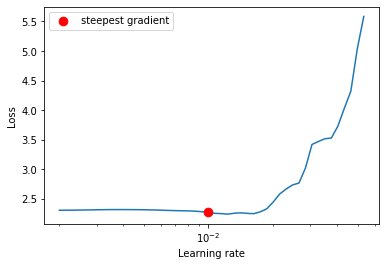

In [5]:
# Setting up LR Finder
model = ResNet18()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = LRFinder(model, optimizer, F.cross_entropy, device=device)

# Starting range test
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
res = lr_finder.plot()

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.33E-03


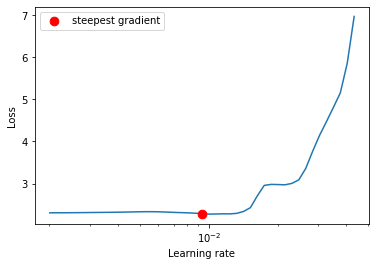

In [6]:
# reseting and starting second range test
lr_finder.reset()
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
res = lr_finder.plot()

## Defining experiments

In [9]:
exps = (
    Experiments.builder()
    .name("ResNet-18")
    .log_directory("./logs")
    .add("lr: 1e-2, Patience: 5, factor: 0.5")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .epochs(epochs)
            .optimizer(optim.SGD, lr=1e-2, momentum=0.9)
            .scheduler(ReduceLROnPlateau, patience=5, factor=0.5)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device(device)
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("lr: 9.33e-03, Patience: 5, factor: 0.5")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .epochs(epochs)
            .optimizer(optim.SGD, lr=9.33E-03, momentum=0.9)
            .scheduler(ReduceLROnPlateau, patience=5, factor=0.5)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device(device)
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

## Running experiments

In [10]:
exps.run()

=> Running experiment: lr: 1e-2, Patience: 5, factor: 0.5
Epoch: 1 / 50
391/391 [==============================] - 58s 149ms/step - train loss: 1.3636 - train accuracy: 50.5440
Test set: Average loss: 1.0267, Accuracy: 6363/10000 (63.63%)

Epoch: 2 / 50
391/391 [==============================] - 60s 154ms/step - train loss: 0.8521 - train accuracy: 69.7960
Test set: Average loss: 0.7714, Accuracy: 7325/10000 (73.25%)

Epoch: 3 / 50
391/391 [==============================] - 62s 159ms/step - train loss: 0.6490 - train accuracy: 77.1540
Test set: Average loss: 0.6476, Accuracy: 7772/10000 (77.72%)

Epoch: 4 / 50
391/391 [==============================] - 62s 159ms/step - train loss: 0.5332 - train accuracy: 81.4540
Test set: Average loss: 0.6155, Accuracy: 7921/10000 (79.21%)

Epoch: 5 / 50
391/391 [==============================] - 63s 162ms/step - train loss: 0.4614 - train accuracy: 83.8540
Test set: Average loss: 0.5973, Accuracy: 8031/10000 (80.31%)

Epoch: 6 / 50
391/391 [=========

## Loss and accuracy plots

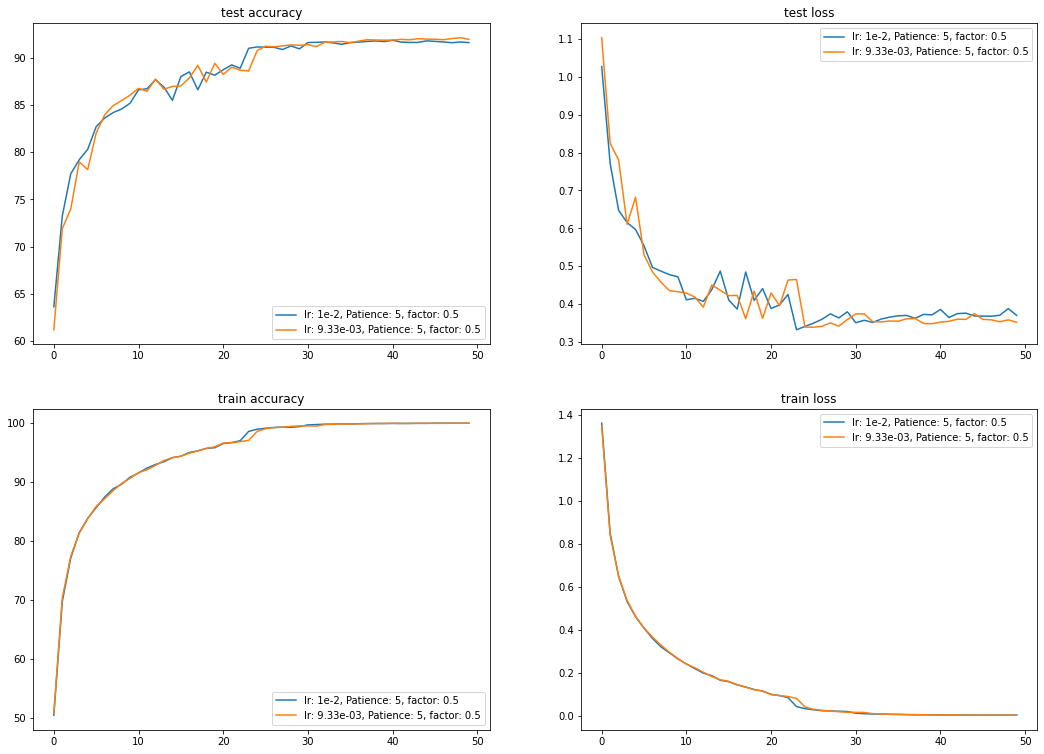

In [13]:
plot_experiments(exps)

## Applying gradcam on the misclassified images generated by both the experiments

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


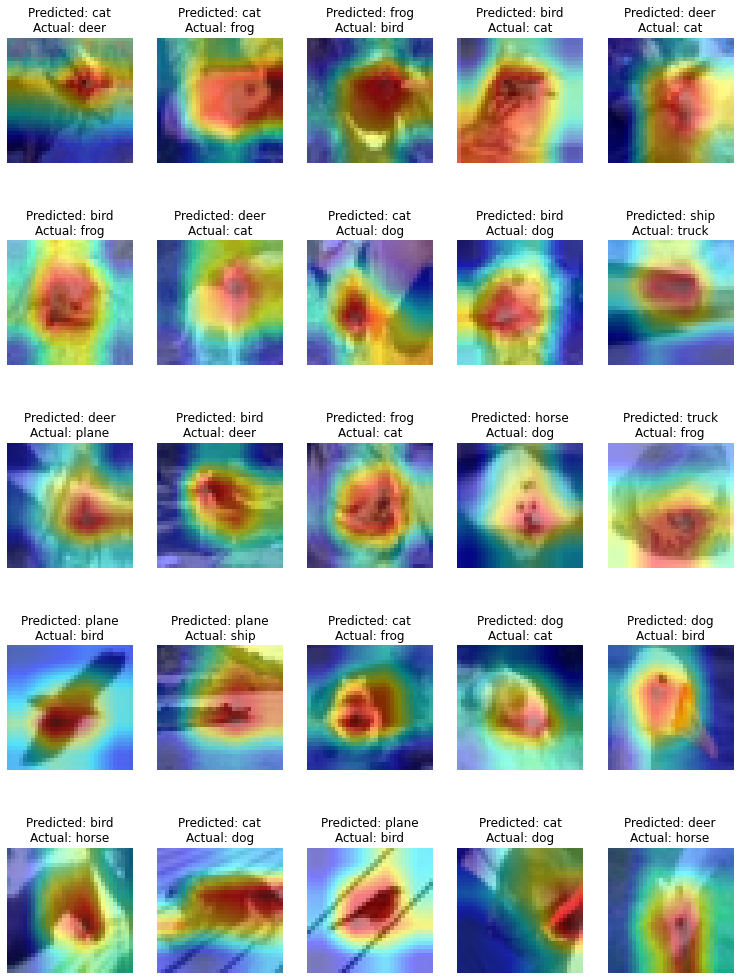

In [20]:
gradcam_misclassified(
    25,
    exps["lr: 1e-2, Patience: 5, factor: 0.5"],
    exps["lr: 1e-2, Patience: 5, factor: 0.5"].get_solver().model.layer4[1],
    test_loader,
    device,
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
    alpha=0.8,
    figsize=(13, 18)
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


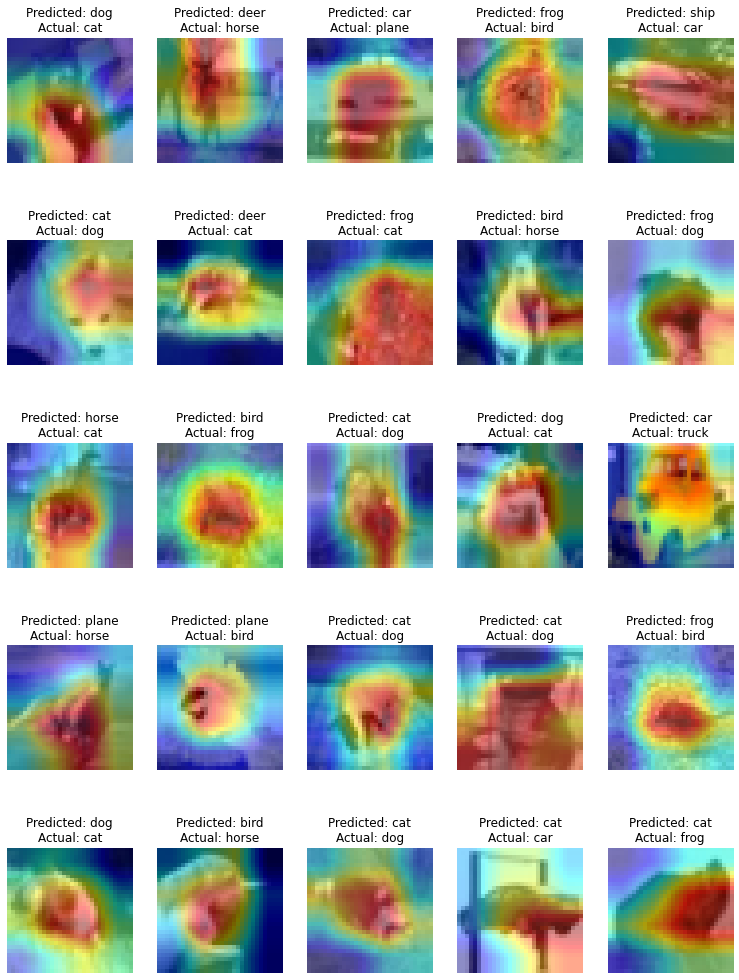

In [21]:
gradcam_misclassified(
    25,
    exps["lr: 9.33e-03, Patience: 5, factor: 0.5"],
    exps["lr: 9.33e-03, Patience: 5, factor: 0.5"].get_solver().model.layer4[1],
    test_loader,
    device,
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
    alpha=0.8,
    figsize=(13, 18)
)